In [1]:
# 导入elasticsearch
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
import pandas as pd

In [2]:
# 连接es
es = Elasticsearch("http://47.74.18.216:9200")

In [3]:
# 定义请求规则,仅查询dns产生的日志下的"event"字段
# query: The elasticsearch query.    
# plugin_id: suricata (1001)、ossec (50001)、 zeek (1234)
query = {
    "_source": {
            "includes": ["event","original"]
        },
        "query": {
            "match_all": {}
        }
}
class JSONObject:
     def __init__(self, d):
        self.__dict__ = d

In [4]:
import json
from pprint import pprint
from collections import OrderedDict

# 使用Scan查询所有数据. 
rel = scan(client=es,             
            query=query,                                     
            scroll='1m',
            index='zeek-*',
            raise_on_error=True,
            preserve_order=False,
            clear_scroll=True)
temp_list = []
temp_dict = {}
# 将相应结果保存到列表.
for i in rel:
    result = list(rel)
    temp = []

# 我们只需要“_source”，它包含所有必需的字段。
    for hit in result:
        temp.append(hit['_source'])
        M=[]
        
#     # Create a dataframe.
#       df = pd.DataFrame(temp)
#     return df

    #统计命中数hits  
    for i in range(len(temp)): 
        n=temp[i].copy()  
        n["hits"]=temp.count(temp[i])
        if not n in M:
            M.append(n)

    
    #换行打印出字典信息
    #         print(M[i], '\n', end="")
    # for i in range(len(M))
    c = 0
    # 目前一共捕获131条，暂时取120条
    while c<120:
        event_dict = M[c]['event']
        jsondict_dict = event_dict['original']
        # 把jsondict_dict（json，即str格式）再转一次json格式获得字典格式的数据
        original_dict = json.loads(jsondict_dict)
        temp_list.append(original_dict)
#         print(type(original_dict))
#         print(original_dict, '\n', end="")
        c = c+1
    print(temp_list, '\n', end="")
        

[{'ts': '2022-05-19T01:00:01.739026Z', 'uid': 'Cs61Af19QTsh7d5E29', 'id.orig_h': '172.16.170.146', 'id.orig_p': 59002, 'id.resp_h': '100.100.2.138', 'id.resp_p': 53, 'proto': 'udp', 'trans_id': 37557, 'query': '238.7.248.197.in-addr.arpa', 'rcode': 0, 'rcode_name': 'NOERROR', 'AA': False, 'TC': False, 'RD': False, 'RA': True, 'Z': 0, 'answers': ['197-248-7-238.safaricombusiness.co.ke'], 'TTLs': [3600.0], 'rejected': False}, {'ts': '2022-05-20T02:40:13.601309Z', 'uid': 'CYGs593zieSkgnbsx3', 'id.orig_h': '172.16.170.146', 'id.orig_p': 45586, 'id.resp_h': '100.100.2.136', 'id.resp_p': 53, 'proto': 'udp', 'trans_id': 44674, 'query': 'ap-northeast-1.axt.aliyun.com', 'rcode': 0, 'rcode_name': 'NOERROR', 'AA': False, 'TC': False, 'RD': False, 'RA': True, 'Z': 0, 'answers': ['100.100.0.76'], 'TTLs': [300.0], 'rejected': False}, {'ts': '2022-05-18T05:00:00.660347Z', 'uid': 'CF7xbF4of3YpVoUv9', 'id.orig_h': '172.16.170.146', 'id.orig_p': 46067, 'id.resp_h': '100.100.2.138', 'id.resp_p': 53, 'pro

In [32]:
# 将获得的字典列表转换为DataFrame
df = pd.DataFrame(temp_list)

print('Read in {:d} Rows...'.format(len(df)))
print(df.head())

Read in 120 Rows...
                            ts                 uid       id.orig_h  id.orig_p  \
0  2022-05-19T01:00:01.739026Z  Cs61Af19QTsh7d5E29  172.16.170.146      59002   
1  2022-05-20T02:40:13.601309Z  CYGs593zieSkgnbsx3  172.16.170.146      45586   
2  2022-05-18T05:00:00.660347Z   CF7xbF4of3YpVoUv9  172.16.170.146      46067   
3  2022-05-19T01:00:01.745576Z  Cuf3k34XI3UhglQszl  172.16.170.146      60267   
4  2022-05-20T02:42:56.839481Z  Cz37nP1VfUuM3p9yN7   91.134.185.91        514   

        id.resp_h  id.resp_p proto  trans_id                          query  \
0   100.100.2.138         53   udp     37557     238.7.248.197.in-addr.arpa   
1   100.100.2.136         53   udp     44674  ap-northeast-1.axt.aliyun.com   
2   100.100.2.138         53   udp     29963                            NaN   
3   100.100.2.138         53   udp     57555                            NaN   
4  172.16.170.146         53   udp     13551                   version.bind   

   rcode  ...     

In [6]:
# 挑选出感兴趣的字段
features = ['id.resp_p', 'rcode_name', 'id.orig_p', 'trans_id']

In [7]:
# 显示具有混合特征类型的数据框
df[features].head()

,id.resp_p,rcode_name,id.orig_p,trans_id
0,53,NOERROR,59002,37557
1,53,NOERROR,45586,44674
2,53,NXDOMAIN,46067,29963
3,53,NXDOMAIN,60267,57555
4,53,NaN,514,13551


In [8]:
import zat
from zat.log_to_dataframe import LogToDataFrame
from zat.dataframe_to_matrix import DataFrameToMatrix
print('zat: {:s}'.format(zat.__version__))
import pandas as pd
print('Pandas: {:s}'.format(pd.__version__))
import numpy as np
print('Numpy: {:s}'.format(np.__version__))
import sklearn
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
print('Scikit Learn Version:', sklearn.__version__)

zat: 0.4.4
Pandas: 1.0.4
Numpy: 1.18.5
Scikit Learn Version: 0.22.2.post1


In [9]:
# 使用zat的DataframeToMatrix类将spark Dataframe转换成np array(即将特征分类转换成数值形式)
# 注意，此处的fit_transform为DataFrameToMatrix中的方法（但是作用和scikit-learn中的同名方法类似）
# 都是对部分数据先拟合fit，根据转换目的找到一些数据中的指标（均值、方差、最大值最小值等），然后进行转换transform，从而实现数据的标准化
to_matrix = DataFrameToMatrix()
zeek_matrix = to_matrix.fit_transform(df[features], normalize=True)
print(zeek_matrix.shape)
zeek_matrix[:1]

Changing column rcode_name to category...
Normalizing column id.resp_p...
Normalizing column id.orig_p...
Normalizing column trans_id...
(120, 6)


array([[0.       , 0.9785675, 0.5777822, 1.       , 0.       , 0.       ]],
      dtype=float32)

In [10]:
# 使用隔离森林模型训练(无监督)/拟合和预测异常实例

# contamination为用户设置的异常样本的比例（没有深究算法，不太了解其设置的依据）
odd_clf = IsolationForest(behaviour='new', contamination=0.25)
odd_clf.fit(zeek_matrix)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


IsolationForest(behaviour='new', bootstrap=False, contamination=0.25,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [11]:
# 调用训练好的树进行异常检测
# odd_clf.predict的返回值为：+1 表示正常样本， -1表示异常样本
odd_df = df[features][odd_clf.predict(zeek_matrix) == -1]
print(odd_df.shape)
odd_df.head()

(30, 4)


,id.resp_p,rcode_name,id.orig_p,trans_id
0,53,NOERROR,59002,37557
3,53,NXDOMAIN,60267,57555
4,53,NaN,514,13551
13,137,NaN,37618,58840
26,53,NXDOMAIN,33089,32127


In [12]:
# 使用KMeans 和 PCA 算法进一步分析异常数据帧
# 通过zat把异常数据df转换为np array
odd_matrix = to_matrix.fit_transform(odd_df)

Changing column rcode_name to category...
Normalizing column id.resp_p...
Normalizing column id.orig_p...
Normalizing column trans_id...


In [36]:
# 设置簇个数为3对异常数据进行聚类
kmeans = KMeans(n_clusters=3).fit_predict(odd_matrix) 
# 数据降维，以便可视化
pca = PCA(n_components=3).fit_transform(odd_matrix)

# 结果添加至dataframe
odd_df['x'] = pca[:, 0] # PCA X Column
odd_df['y'] = pca[:, 1] # PCA Y Column
odd_df['cluster'] = kmeans
# odd_df.head()
# odd_df.set_index('cluster') ## 将类簇设置为索引
odd_df.head()

,id.resp_p,rcode_name,id.orig_p,trans_id,x,y,cluster
0,53,NOERROR,59002,37557,-0.645889,-0.302540,1
3,53,NXDOMAIN,60267,57555,0.798019,-0.372417,0
4,53,NaN,514,13551,0.028017,1.067372,2
13,137,NaN,37618,58840,0.133320,0.752853,2
26,53,NXDOMAIN,33089,32127,0.738760,-0.184166,0


In [14]:
# 创建存放聚类结果的es索引
try:
    result = es.indices.create(index='cluster')
    print(result)
except Exception as err:
    print(err)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'cluster'}


In [37]:
# 将dataframe转为json
odd_json = odd_df.to_json(orient ='index')#orient ='records'；orient ='index'
pprint(odd_json)

'{"0":{"id.resp_p":53,"rcode_name":"NOERROR","id.orig_p":59002,"trans_id":37557,"x":-0.6458892226,"y":-0.3025395274,"cluster":1},"3":{"id.resp_p":53,"rcode_name":"NXDOMAIN","id.orig_p":60267,"trans_id":57555,"x":0.7980194092,"y":-0.3724173009,"cluster":0},"4":{"id.resp_p":53,"rcode_name":null,"id.orig_p":514,"trans_id":13551,"x":0.0280167218,"y":1.0673719645,"cluster":2},"13":{"id.resp_p":137,"rcode_name":null,"id.orig_p":37618,"trans_id":58840,"x":0.1333204657,"y":0.7528526783,"cluster":2},"26":{"id.resp_p":53,"rcode_name":"NXDOMAIN","id.orig_p":33089,"trans_id":32127,"x":0.7387603521,"y":-0.1841662079,"cluster":0},"30":{"id.resp_p":53,"rcode_name":"NXDOMAIN","id.orig_p":37669,"trans_id":65002,"x":0.8147243857,"y":-0.3779391348,"cluster":0},"40":{"id.resp_p":53,"rcode_name":"NXDOMAIN","id.orig_p":60154,"trans_id":33954,"x":0.7435522676,"y":-0.2384622097,"cluster":0},"41":{"id.resp_p":53,"rcode_name":"NXDOMAIN","id.orig_p":58805,"trans_id":62612,"x":0.8096585274,"y":-0.3987070918,"clus

In [29]:
# 把json格式的聚类结果上载到es
try:
    es.index(index='cluster2', document=odd_json)
except Exception as err:
    print(err)


In [73]:
# Plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14.0
plt.rcParams['figure.figsize'] = 15.0, 6.0

# 用于绘制散点图/蜂群图
def jitter(arr):
    stdev = .02*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

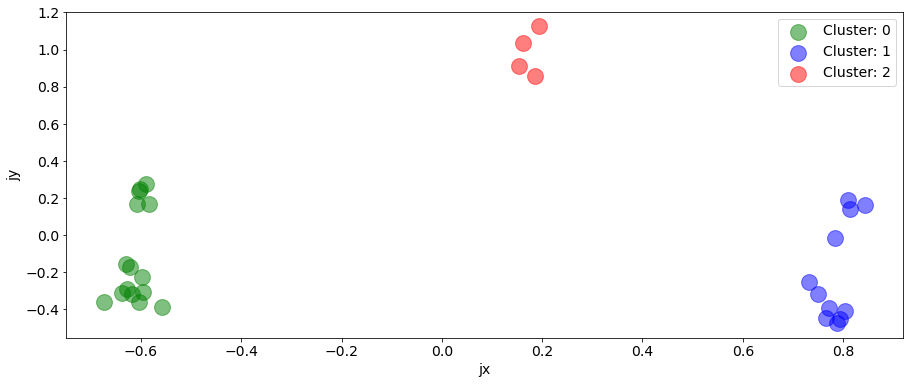

In [74]:
# 将重合数据点进行抖动处理以便观察
odd_df['jx'] = jitter(odd_df['x'])
odd_df['jy'] = jitter(odd_df['y'])

# 使用数据进行聚类
cluster_groups = odd_df.groupby('cluster')

# 绘制机器学习（聚类）结果
colors = {0:'green', 1:'blue', 2:'red', 3:'orange', 4:'purple', 5:'brown'}
fig, ax = plt.subplots()
for key, group in cluster_groups:
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=250,
               label='Cluster: {:d}'.format(key), color=colors[key])

In [75]:
# 打印每个簇内的数据
pd.set_option('display.width', 1000)
for key, group in cluster_groups:
    print('\nCluster {:d}: {:d} observations'.format(key, len(group)))
    print(group[features].head())


Cluster 0: 15 observations
    id.resp_p rcode_name  id.orig_p  trans_id
1          53   NXDOMAIN      56791     11833
7          53   NXDOMAIN      34433     32479
8          53   NXDOMAIN      33089     32127
13         53   NXDOMAIN      58805     62612
15         53   NXDOMAIN      35192      1832

Cluster 1: 11 observations
    id.resp_p rcode_name  id.orig_p  trans_id
22         53    NOERROR      50032     62478
35         53    NOERROR      37494     61641
37         53    NOERROR      32791     48207
45         53    NOERROR      60544      3017
48         53    NOERROR      33717     37883

Cluster 2: 4 observations
    id.resp_p rcode_name  id.orig_p  trans_id
20         53        NaN      45052     17767
21         53        NaN      56276     13551
43         53        NaN      56824     13551
46         53        NaN      47387     64206


#### <div style="float: right; margin: 10px 10px 10px 10px"></div>
## 各个簇表示的异常的分类
- Cluster 0: 代码相应描述为NXDOMAIN的
- Cluster 1: 代码相应描述为NOERROR的
- Cluster 2: 未知代码相应描述（异常值）
